In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

import tensorflow as tf

from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras import initializers, regularizers, constraints
from keras import backend as K
from keras.models import Model, Sequential, Input
import keras

from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

import matplotlib.pyplot as plt
import seaborn as sns

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Using TensorFlow backend.


In [2]:
source = pd.read_table('../archive/source_BIO_2014_cropus.txt', header=None, nrows=1e4)
target = pd.read_table('../archive/target_BIO_2014_cropus.txt', header=None, nrows=1e4)

In [3]:
WORD_NUM = 100

In [4]:
x = source[0].tolist()

In [5]:
y = target[0].tolist()

In [6]:
x = [i.split(' ') for i in x]
y = [i.split(' ') for i in y]

In [7]:
x[:1]

[['人',
  '民',
  '网',
  '1',
  '月',
  '1',
  '日',
  '讯',
  '据',
  '《',
  '纽',
  '约',
  '时',
  '报',
  '》',
  '报',
  '道',
  ',',
  '美',
  '国',
  '华',
  '尔',
  '街',
  '股',
  '市',
  '在',
  '2',
  '0',
  '1',
  '3',
  '年',
  '的',
  '最',
  '后',
  '一',
  '天',
  '继',
  '续',
  '上',
  '涨',
  ',',
  '和',
  '全',
  '球',
  '股',
  '市',
  '一',
  '样',
  ',',
  '都',
  '以',
  '最',
  '高',
  '纪',
  '录',
  '或',
  '接',
  '近',
  '最',
  '高',
  '纪',
  '录',
  '结',
  '束',
  '本',
  '年',
  '的',
  '交',
  '易',
  '。']]

In [8]:
y[:1]

[['O',
  'O',
  'O',
  'B_T',
  'I_T',
  'I_T',
  'I_T',
  'O',
  'O',
  'O',
  'B_LOC',
  'I_LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B_LOC',
  'I_LOC',
  'I_LOC',
  'I_LOC',
  'I_LOC',
  'O',
  'O',
  'O',
  'B_T',
  'I_T',
  'I_T',
  'I_T',
  'I_T',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']]

In [9]:
x_length = [len(i) for i in x]
x_length

[70,
 84,
 90,
 133,
 140,
 119,
 180,
 119,
 210,
 170,
 100,
 79,
 57,
 94,
 87,
 48,
 74,
 63,
 133,
 14,
 38,
 55,
 100,
 69,
 76,
 79,
 12,
 87,
 22,
 64,
 157,
 82,
 11,
 175,
 93,
 100,
 51,
 133,
 197,
 285,
 244,
 74,
 56,
 17,
 77,
 27,
 81,
 24,
 28,
 50,
 31,
 37,
 23,
 47,
 29,
 52,
 10,
 36,
 39,
 57,
 29,
 45,
 30,
 5,
 161,
 17,
 77,
 121,
 126,
 122,
 136,
 15,
 111,
 123,
 68,
 114,
 178,
 154,
 16,
 122,
 153,
 117,
 14,
 103,
 121,
 58,
 128,
 17,
 98,
 141,
 121,
 85,
 35,
 100,
 133,
 151,
 135,
 17,
 158,
 88,
 15,
 11,
 22,
 231,
 351,
 227,
 545,
 43,
 10,
 23,
 59,
 158,
 172,
 314,
 256,
 355,
 30,
 177,
 171,
 80,
 128,
 132,
 147,
 184,
 197,
 519,
 616,
 204,
 85,
 77,
 135,
 63,
 180,
 134,
 84,
 148,
 90,
 141,
 48,
 85,
 118,
 133,
 96,
 57,
 84,
 142,
 62,
 112,
 146,
 220,
 313,
 149,
 262,
 285,
 95,
 13,
 73,
 113,
 13,
 37,
 86,
 47,
 61,
 96,
 15,
 54,
 77,
 47,
 79,
 14,
 66,
 41,
 42,
 142,
 39,
 7,
 138,
 8,
 46,
 92,
 9,
 80,
 56,
 11,
 139,
 

In [10]:
pd.DataFrame(x_length)[0].value_counts()[:10]

10    166
12    142
9     130
11    127
14    123
13    116
8     111
7     111
5     110
20    103
Name: 0, dtype: int64

In [11]:
# %%time
# x_x = []
# y_y = []
# for m, n in enumerate(x):
#     if len(n) >= WORD_NUM or len(n) >= WORD_NUM / 2:
#         x_x.append(n)
#         y_y.append(y[m])

In [12]:
# x = x_x
# y = y_y

In [13]:
def create(i):
    global num
    temp = []
    
    for g in i:
        try:
            corpus[g]
            temp.append(corpus[g])
        except:
            corpus[g] = num
            temp.append(corpus[g])
            num += 1
    return temp

In [14]:
corpus = {}
corpus['<PAD>'] = 0
corpus['<UNK>'] = 1

num = 2

In [15]:
text = []
for i in x:
    temp = create(i)
    text.append(temp)

In [16]:
text[:1]

[[2,
  3,
  4,
  5,
  6,
  5,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  14,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  5,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  17,
  39,
  40,
  41,
  23,
  24,
  33,
  42,
  17,
  43,
  44,
  31,
  45,
  46,
  47,
  48,
  49,
  50,
  31,
  45,
  46,
  47,
  51,
  52,
  53,
  29,
  30,
  54,
  55,
  56]]

In [17]:
text = pad_sequences(text, maxlen=WORD_NUM, padding='post', value=0)

In [18]:
label = []
for i in y:
    label += i

In [19]:
targ = dict(zip(set(label), range(9)))

In [20]:
targ

{'B_ORG': 0,
 'I_PER': 1,
 'I_LOC': 2,
 'B_T': 3,
 'I_ORG': 4,
 'B_PER': 5,
 'I_T': 6,
 'O': 7,
 'B_LOC': 8}

In [21]:
def create_label(i):
    temp = []
    
    for g in i:
        temp.append(targ[g])
    return temp

In [22]:
label = []
for i in y:
    temp = create_label(i)
    label.append(temp)

In [23]:
label[:1]

[[7,
  7,
  7,
  3,
  6,
  6,
  6,
  7,
  7,
  7,
  8,
  2,
  7,
  7,
  7,
  7,
  7,
  7,
  8,
  2,
  2,
  2,
  2,
  7,
  7,
  7,
  3,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7]]

In [24]:
label = pad_sequences(label, maxlen=WORD_NUM, padding='post', value=targ['O'])

In [25]:
label.shape

(10000, 100)

In [26]:
dv_targ = [{i: str(i)} for i in range(9)]
dv_targ

[{0: '0'},
 {1: '1'},
 {2: '2'},
 {3: '3'},
 {4: '4'},
 {5: '5'},
 {6: '6'},
 {7: '7'},
 {8: '8'}]

In [27]:
dv = DictVectorizer(sparse=False)
dv.fit(dv_targ)

DictVectorizer(sparse=False)

In [28]:
dv.feature_names_

['0=0', '1=1', '2=2', '3=3', '4=4', '5=5', '6=6', '7=7', '8=8']

In [29]:
label = label.astype(str)

In [30]:
label

array([['7', '7', '7', ..., '7', '7', '7'],
       ['7', '8', '2', ..., '7', '7', '7'],
       ['7', '3', '6', ..., '7', '7', '7'],
       ...,
       ['7', '7', '7', ..., '7', '7', '7'],
       ['7', '7', '7', ..., '7', '7', '7'],
       ['7', '7', '7', ..., '1', '1', '7']], dtype='<U11')

In [31]:
%%time
l = []
for i in range(label.shape[0]):
    temp = []
    for g in range(label.shape[1]):
        t = dv.transform({
            eval(label[i, g]): label[i, g]
        })
        temp.append(t[0].tolist())
    l.append(temp)

Wall time: 1min 6s


In [32]:
label = np.array(l)

In [33]:
label.shape

(10000, 100, 9)

In [34]:
class Attention(layers.Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [35]:
embedding_len = len(corpus) + 1
n_tag = len(targ.keys())
embedding_size = 100

In [36]:
x_train, x_test, y_train, y_test = train_test_split(text, label, test_size=0.2)

In [37]:
x_train.shape, y_train.shape

((8000, 100), (8000, 100, 9))

In [38]:
x_test.shape, y_test.shape

((2000, 100), (2000, 100, 9))

In [39]:
lstm_units = int(x_train.shape[1] * n_tag / 2)
# lstm_units = 32

In [40]:
inp = layers.Input(shape=(WORD_NUM, ))
x = layers.Embedding(embedding_len, embedding_size, input_length=WORD_NUM)(inp)
x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)

x = Attention(WORD_NUM)(x)
x = layers.Reshape((WORD_NUM, n_tag))(x)
# x = layers.TimeDistributed(layers.Dense(n_tag, activation="relu"))(x)
x = layers.Activation('softmax')(x)
x = CRF(n_tag, sparse_target=True)(x)

model = Model(inputs=inp, outputs=x)

# adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(loss=crf_loss,
              optimizer='adam',
              metrics=[crf_accuracy])

# model.compile(loss='categorical_crossentropy',
#               optimizer=keras.optimizers.Adam(0.001),
#               metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          407100    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 900)          1983600   
_________________________________________________________________
attention_1 (Attention)      (None, 900)               1000      
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 9)            0         
_________________________________________________________________
activation_1 (Activation)    (None, 100, 9)            0         
_________________________________________________________________
crf_1 (CRF)                  (None, 100, 9)            189 

In [41]:
history = model.fit(x_train, y_train, batch_size=256, epochs=5, validation_data=(x_test, y_test))
# history = model.fit(text, label, batch_size=256, epochs=5)

D:\anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 23s 3ms/step - loss: 1.4387 - crf_accuracy: 0.9995 - val_loss: 1.3143 - val_crf_accuracy: 0.9994
Epoch 2/10
8000/8000 [==============================] - 22s 3ms/step - loss: 1.2626 - crf_accuracy: 0.9995 - val_loss: 1.2131 - val_crf_accuracy: 0.9994
Epoch 3/10
8000/8000 [==============================] - 23s 3ms/step - loss: 1.1723 - crf_accuracy: 0.9995 - val_loss: 1.1283 - val_crf_accuracy: 0.9994
Epoch 4/10
8000/8000 [==============================] - 23s 3ms/step - loss: 1.0896 - crf_accuracy: 0.9995 - val_loss: 1.0475 - val_crf_accuracy: 0.9994
Epoch 5/10
8000/8000 [==============================] - 23s 3ms/step - loss: 1.0099 - crf_accuracy: 0.9995 - val_loss: 0.9687 - val_crf_accuracy: 0.9994
Epoch 6/10
8000/8000 [==============================] - 23s 3ms/step - loss: 0.9320 - crf_accuracy: 0.9995 - val_loss: 0.8926 - val_crf_accuracy: 0.9994
Epoch 7/10
8000/8000 [============

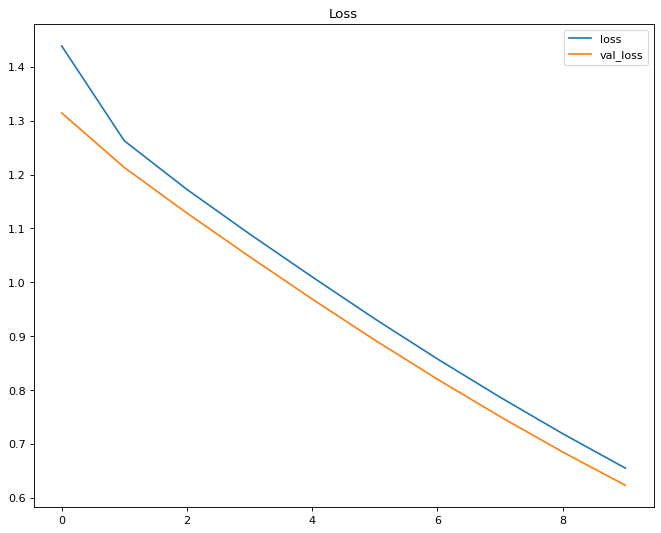

In [42]:
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

Text(0.5, 1.0, 'Acc')

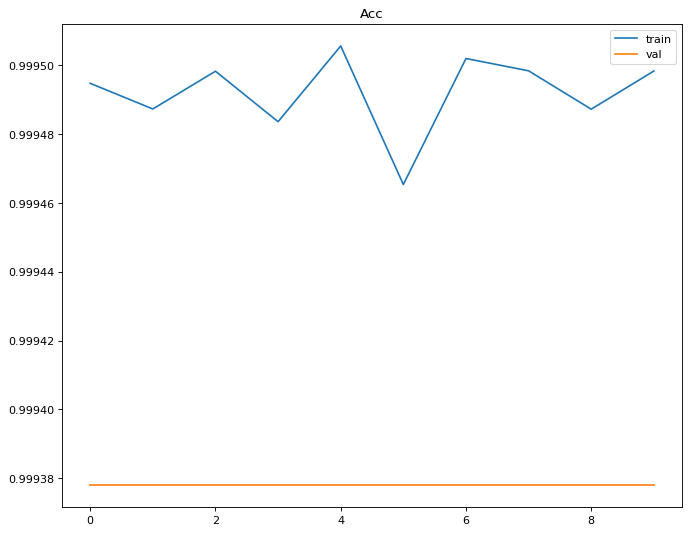

In [43]:
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history['crf_accuracy'], label='train')
plt.plot(history.history['val_crf_accuracy'], label='val')
plt.legend()
plt.title('Acc')

In [44]:
model.evaluate(x_test, y_test)

2000/2000 [==============================] - 7s 4ms/step


[0.6230074944496155, 0.9993895888328552]

In [45]:
text[1]

array([10, 11, 12, 13, 14, 15, 14, 16, 57, 17, 58, 59, 60, 27, 27, 61, 62,
       63, 29, 37, 64, 26, 65, 66, 67, 68, 17, 69,  5, 65, 65, 70, 29, 44,
       71, 30, 31, 72, 38, 73, 74, 16, 75, 76, 77, 78, 79, 80, 61, 62, 37,
       64, 26, 67, 66, 60, 68, 17, 69,  5, 65, 65, 67, 29, 44, 71, 30, 31,
       72, 38, 73, 74, 81, 76, 82, 83, 37, 38, 28, 84, 66, 28, 68, 56,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [46]:
pre = model.predict(text[1].reshape(-1, WORD_NUM))

In [47]:
pre

array([[[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0

In [48]:
np.argmax(pre, axis=-1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [49]:
np.argmax(label[1], axis=-1)

array([7, 8, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 6, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 3, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 0, 4, 4,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 6, 6, 6, 6, 7, 7,
       7, 7, 7, 7, 7, 7, 5, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int64)

In [50]:
targ

{'B_ORG': 0,
 'I_PER': 1,
 'I_LOC': 2,
 'B_T': 3,
 'I_ORG': 4,
 'B_PER': 5,
 'I_T': 6,
 'O': 7,
 'B_LOC': 8}

In [51]:
dv.inverse_transform(pre[0][0].reshape(1, -1))

[{'0=0': 1.0}]

In [52]:
# class NERInference:
#     def __init__(self, model, words, word2idx, tags, n_words, maxlen, split_pattern="(,|!|\.| +)"):
#         self.model = model
#         self.words = words
#         self.word2idx = word2idx
#         self.tags = tags
#         self.n_words = n_words
#         self.pattern = split_pattern
#         self.maxlen = maxlen
        
#     def predict(self, string):
#         preds = []
#         tokens = [[self.word2idx[word] for word in string if word in self.words]]
#         padded = pad_sequences(tokens, maxlen=self.maxlen, padding='post', value=self.n_words-1)
#         pred_ner = np.argmax(self.model.predict(padded), axis=-1)
#         for w,pred in zip(padded[0], pred_ner[0]):
#             if w == self.n_words - 1:
#                 break
#             #print("{:15}: {}".format(self.words[w], self.tags[pred]))
#             preds.append(self.tags[pred])
#         return preds

# myNerInfer = NERInference(model, word2idx=word2idx, words=words, tags=tags, n_words=n_words, maxlen=maxlen)

# new_string4 = '王小明出生在北京'
# new_string4_pred = myNerInfer.predict(string=new_string4)
# new_string4_pred

# class FindNamedEntites(object):
#     new_string_pred = []
#     new_string = ''
    
#     def __init__(self, new_string):
#         self.new_string = new_string
        
#     def make_preds(self):
#         self.new_string_pred = myNerInfer.predict(string=self.new_string)
#     def find_person(self, new_string):
#         if len(self.new_string_pred)==0:
#             self.new_string_pred = myNerInfer.predict(string=new_string)
#         persons = []
#         person = ''
#         for w, t in zip(new_string, self.new_string_pred):
#             if t == 'B-PER' or t == 'I-PER':
#                 person+=w
#             else:
#                 if person!='': persons.append(person)
#                 person=''
#         return persons
#     def find_org(self, new_string):
#         if len(self.new_string_pred)==0:
#             self.new_string_pred = myNerInfer.predict(string=new_string)
#         persons = []
#         person = ''
#         for w, t in zip(new_string, self.new_string_pred):
#             if t == 'B-ORG' or t == 'I-ORG':
#                 person+=w
#             else:
#                 if person!='': persons.append(person)
#                 person=''
#         return persons
#     def find_loc(self, new_string):
#         if len(self.new_string_pred)==0:
#             self.new_string_pred = myNerInfer.predict(string=new_string)
#         if new_string:
#             self.new_string_pred = myNerInfer.predict(string=new_string)
#         persons = []
#         person = ''
#         for w, t in zip(new_string, self.new_string_pred):
#             if t == 'B-LOC' or t == 'I-LOC':
#                 person+=w
#             else:
#                 if person!='': persons.append(person)
#                 person=''
#         return persons

#     def find_ner(self):
#         persons = self.find_person(self.new_string)
#         orgs = self.find_org(self.new_string)
#         locs = self.find_loc(self.new_string)
#         print("{:12} : ".format('PERSON'), persons)
#         print("{:12} : ".format('ORGNIZATION'), orgs)
#         print("{:12} : ".format('LOCATION'), locs)

# ner_recog = FindNamedEntites('王硕出生在广州，他现在在中国大使馆纽约办事处工作。他说下次回国的时候要去黄山旅游，他不喜欢跟着广州市教育局去，想要自驾游')
# ner_recog.make_preds()
# ner_recog.find_ner()

# print(ner_recog.find_loc('从广州到北京的交通路线'))
# print(ner_recog.find_loc('怎么样从北京去到广州呢？'))